In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler   
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.algorithms import QSVC


In [2]:
df = pd.read_csv('stunting.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


In [3]:
df = df.drop_duplicates()

In [4]:
print(df)

      Jenis Kelamin  Umur (bulan)  Tinggi Badan (cm)  Berat Badan (kg)  \
0         Laki-laki            19               91.6              13.3   
1         Laki-laki            20               77.7               8.5   
2         Laki-laki            10               79.0              10.3   
3         Perempuan             2               50.3               8.3   
4         Perempuan             5               56.4              10.9   
...             ...           ...                ...               ...   
99993     Laki-laki            12               83.4              11.8   
99994     Laki-laki            11               81.1               8.8   
99995     Laki-laki            11               75.3               7.3   
99996     Laki-laki            21               93.7              14.8   
99997     Perempuan            18               82.9              12.6   

               Stunting             Wasting  
0                  Tall  Risk of Overweight  
1               Stu

In [5]:
df = df.drop('Wasting', axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92692 entries, 0 to 99997
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Jenis Kelamin      92692 non-null  object 
 1   Umur (bulan)       92692 non-null  int64  
 2   Tinggi Badan (cm)  92692 non-null  float64
 3   Berat Badan (kg)   92692 non-null  float64
 4   Stunting           92692 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 4.2+ MB


In [7]:
label_encoder = LabelEncoder()

# Loop through each column and apply LabelEncoder to object columns
for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])

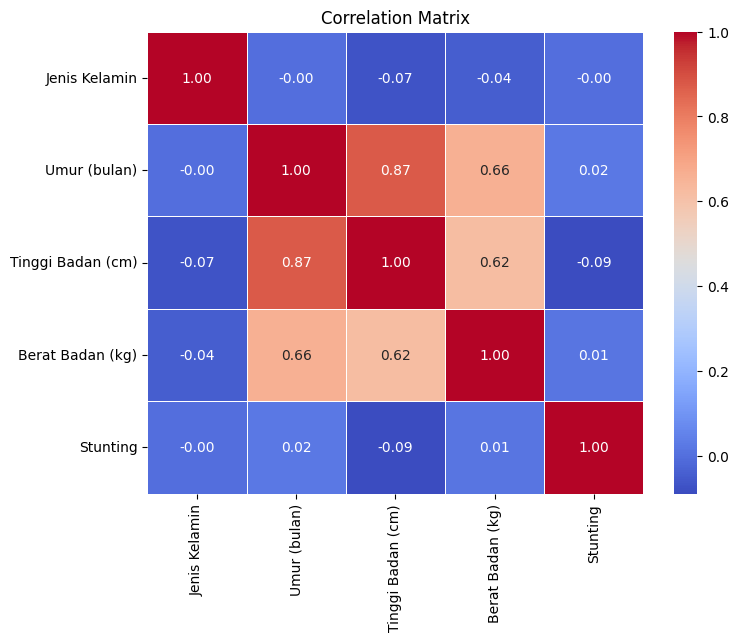

In [8]:
correlation_matrix = df.corr()

# Set the figure size
plt.figure(figsize=(8, 6))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

In [ ]:
from sklearn.utils import resample

target_per_class = 250   # karena 1,000 ÷ 4 kelas

frames = []
for label, subset in df.groupby('Stunting'):
    if len(subset) >= target_per_class:
        frames.append(subset.sample(n=target_per_class, random_state=42))
    else:
        frames.append(
            resample(subset, replace=True, n_samples=target_per_class, random_state=42)
        )

df_reduced = pd.concat(frames).sample(frac=1, random_state=42).reset_index(drop=True)
print(df_reduced['Stunting'].value_counts()) 


In [10]:
X = df_reduced.drop('Stunting', axis=1)
y = df_reduced['Stunting']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# --- 1. Reduksi dimensi ---
pca = PCA(n_components=0.95, svd_solver='full')   # jaga ≥95 % varians
X_train_red = pca.fit_transform(X_train_scaled)
X_test_red  = pca.transform(X_test_scaled)
num_qubits  = X_train_red.shape[1]

# --- 2. Quantum kernel ---
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1, entanglement="linear")
sampler  = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
q_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

# --- 3. SVM training ---
model = SVC(kernel=q_kernel.evaluate)
model.fit(X_train_red, y_train)
y_pred   = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Akurasi QSVM  : {acc:.3f}")

# Classification report (precision, recall, f1, support)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
